<a href="https://colab.research.google.com/github/cammylexi/CS2341-Assignment-3/blob/main/LabAssignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load, Split, and Balance

We will import the data from kaggle and then create a df for it. We are not editing, normalizing, or one hot encoding here, just loading up the data.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muonneutrino/us-census-demographic-data")

print("Path to dataset files:", path)

100%|██████████| 10.6M/10.6M [00:01<00:00, 8.53MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muonneutrino/us-census-demographic-data/versions/3


In [ ]:
import pandas as pd

df = pd.read_csv(path + "/acs2017_census_tract_data.csv")
df.head()

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


##Cleaning Dataset

Now we remove all missing data, then encode string data (state and county into integers).

We kept the County variable because of the potential information about how each geographic location affects certain demographic factors. Since differenct counties have different features, it could be useful in understanding trends to make predictions.

In [ ]:
df_cleaned = df.dropna()

df_encoded = df_cleaned.copy()
df_encoded['State'] = df_encoded['State'].astype('category').cat.codes
df_encoded['County'] = df_encoded['County'].astype('category').cat.codes

# Display the first few rows of the cleaned and encoded dataset
df_encoded.head()

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,0,89,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,0,89,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,0,89,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,0,89,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,0,89,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


## Quantize ChildPoverty Variable

Balancing of the dataset should not be done in both the training and testing sets. The testing set represents the real-world data that will be presented in to the model where it will be analyized for the first time. This is to make sure a fair evaluation on the dataset is made and it makes accurate predictions. Balancing should be only done in the training set to prevent bias in the making predictions process. By using different balancing techniques such as equal representation it ensures that each class get the same number of instances (majority class and minority class) to help the model learn all the patterns in each class.

In [ ]:
# Cutting the data
df_encoded['ChildPovertyClass'] = pd.qcut(df_encoded['ChildPoverty'], 4, labels=[0,1,2,3])

# Check the distrubution of the classes of quantization
class_counts = df_encoded['ChildPovertyClass'].value_counts()

#=================================================================================================================================================
# Balancing the data
from collections import Counter

# Count occurrences of each class
counts = Counter(df_encoded['ChildPovertyClass'])

# Find the minimum class count (to balance)
min_size = min(counts.values())

# Take a balanced sample from each class
df_balanced = (df_encoded.groupby('ChildPovertyClass')
                           .apply(lambda x: x.sample(min_size, random_state=42))
                           .reset_index(drop=True))

# Check new distribution
print(df_balanced['ChildPovertyClass'].value_counts())


#=================================================================================================================================================
# Splitting the dataset into training (80%) and testing set (20%)
from sklearn.model_selection import train_test_split

X = df_encoded.drop('ChildPovertyClass', axis=1) # Features
y = df_encoded['ChildPovertyClass'] # Target variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_counts, X_train.shape, X_test.shape

class_counts_train = y_train.value_counts()
class_counts_test = y_test.value_counts()

print("=================================================================================\nTraining class distribution")
print(class_counts_train)
print("=================================================================================\nTesting class distribution")
print(class_counts_test)

ChildPovertyClass
0    18148
1    18148
2    18148
3    18148
Name: count, dtype: int64
Training class distribution
ChildPovertyClass
0    14596
3    14593
2    14538
1    14447
Name: count, dtype: int64
Testing class distribution
ChildPovertyClass
1    3724
0    3633
2    3610
3    3577
Name: count, dtype: int64


<ipython-input-10-bd678221c0e9>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_balanced = (df_encoded.groupby('ChildPovertyClass')
<ipython-input-10-bd678221c0e9>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_size, random_state=42))


#Pre-processig and Intial Modeling

We build this function based on the Two Layer Perceptron that was introduced in class. We make some minor changes so that it works with our code.

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class TwoLayerPerceptron:
    def __init__(self, n_hidden=30, C=0.0, epochs=500, eta=0.001, minibatch_size=64, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.minibatch_size = minibatch_size

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation."""
        return pd.get_dummies(y).values.T

    def _initialize_weights(self, n_features, n_output):
        """Initialize weights using Glorot initialization."""
        limit_1 = np.sqrt(6 / (n_features + self.n_hidden))
        limit_2 = np.sqrt(6 / (self.n_hidden + n_output))

        W1 = np.random.uniform(-limit_1, limit_1, (self.n_hidden, n_features + 1))  # +1 for bias term
        W2 = np.random.uniform(-limit_2, limit_2, (n_output, self.n_hidden + 1))  # +1 for bias term
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((n_output, 1))

        return W1, W2, b1, b2

    @staticmethod
    def _sigmoid(z):
        """Sigmoid activation function."""
        return expit(z)

    @staticmethod
    def _softmax(z):
        """Softmax activation function (for cross-entropy)."""
        exp_values = np.exp(z - np.max(z, axis=0, keepdims=True))  # stability
        return exp_values / np.sum(exp_values, axis=0, keepdims=True)

    @staticmethod
    def _cross_entropy_loss(Y_enc, A3):
        """Cross-entropy loss function."""
        m = Y_enc.shape[1]
        cost = -np.sum(Y_enc * np.log(A3 + 1e-8)) / m  # add small epsilon for stability
        return cost

    def _cost(self, A3, Y_enc, W1, W2):
        """Compute the cost function with regularization."""
        cost = self._cross_entropy_loss(Y_enc, A3)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

    def _L2_reg(self, lambda_, W1, W2):
        """Compute L2 regularization cost."""
        return (lambda_ / 2.0) * (np.sum(W1[:, 1:] ** 2) + np.sum(W2[:, 1:] ** 2))

    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute the feedforward step."""
        A1 = self._add_bias_unit(X)
        Z1 = W1 @ A1.T + b1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2.T)  # Add bias to hidden layer
        Z2 = W2 @ A2.T + b2
        A3 = self._softmax(Z2)  # Softmax for classification
        return A1, Z1, A2, Z2, A3

    def _add_bias_unit(self, X):
        """Add bias unit to the input data."""
        ones = np.ones((X.shape[0], 1))
        return np.hstack((ones, X))

    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """Compute gradient step using backpropagation."""
        V2 = A3 - Y_enc  # For cross-entropy loss

        # FIX: Transpose the result of matrix multiplication to match A2's shape
        # Original: V1 = A2 * (1 - A2) * (W2[:, 1:].T @ V2)
        delta = W2[:, 1:].T @ V2
        # A2 shape is (samples, hidden+1), delta shape is (hidden, samples)
        # We need to transpose delta to match A2's shape
        delta_t = delta.T  # Now shape is (samples, hidden)

        # We need to remove the bias column from A2 for element-wise multiplication
        A2_nobias = A2[:, 1:]  # Remove bias column, now shape is (samples, hidden)
        V1 = A2_nobias * (1 - A2_nobias) * delta_t

        # Now calculate gradients with correct shapes
        gradW2 = V2 @ A2
        gradW1 = V1.T @ A1
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1.T, axis=1).reshape((-1, 1))

        # Regularize weights that are not bias terms
        gradW1[:, 1:] += self.l2_C * W1[:, 1:]
        gradW2[:, 1:] += self.l2_C * W2[:, 1:]

        return gradW1, gradW2, gradb1, gradb2

    def fit(self, X, y):
        """Train the model using mini-batches and update weights."""
        Y_enc = self._encode_labels(y)
        n_features = X.shape[1]
        n_output = Y_enc.shape[0]

        # Initialize weights
        W1, W2, b1, b2 = self._initialize_weights(n_features, n_output)

        cost_history = []
        for epoch in range(self.epochs):
            minibatch_cost = 0

            # Shuffle and split the data into mini-batches
            permutation = np.random.permutation(X.shape[0])
            X_shuffled = X[permutation]
            Y_enc_shuffled = Y_enc[:, permutation]

            for i in range(0, X.shape[0], self.minibatch_size):
                X_batch = X_shuffled[i:i+self.minibatch_size]
                Y_batch = Y_enc_shuffled[:, i:i+self.minibatch_size]

                # Feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_batch, W1, W2, b1, b2)

                # Compute cost
                minibatch_cost = self._cost(A3, Y_batch, W1, W2)

                # Backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1, A2, A3, Z1, Z2, Y_batch, W1, W2)

                # Update weights and biases
                W1 -= self.eta * gradW1
                W2 -= self.eta * gradW2
                b1 -= self.eta * gradb1
                b2 -= self.eta * gradb2

            cost_history.append(minibatch_cost)

        self.W1, self.W2, self.b1, self.b2 = W1, W2, b1, b2
        self.cost_ = cost_history
        return self

    def predict(self, X):
        """Predict class labels."""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        return np.argmax(A3, axis=0)

## First Model: Raw Data

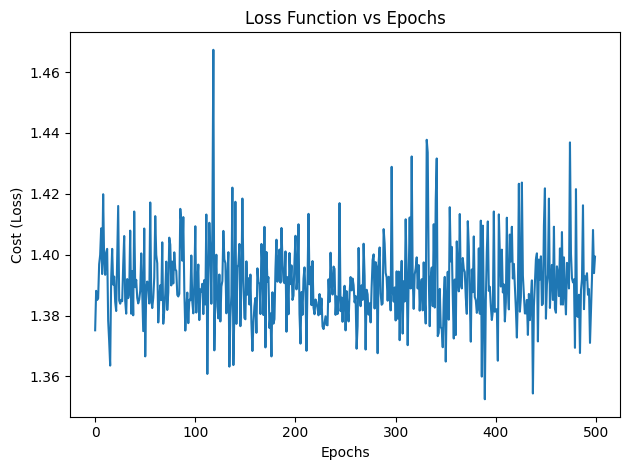

Accuracy: 0.2459


In [ ]:
mlp = TwoLayerPerceptron(n_hidden=30, epochs=500, eta=0.001, minibatch_size=64)
mlp.fit(X_train.values, y_train.values)

# Predictions and accuracy
y_pred = mlp.predict(X_test.values)
accuracy = accuracy_score(y_test, y_pred)

# Plot the loss function vs. epochs
plt.plot(range(len(mlp.cost_)), mlp.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost (Loss)")
plt.title("Loss Function vs Epochs")
plt.tight_layout()
plt.show()

# Output accuracy
print(f"Accuracy: {accuracy:.4f}")

## Second Model: Normalized Data

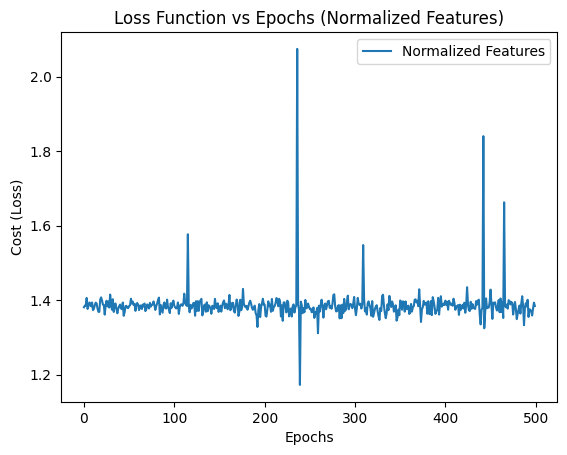

Accuracy (Normalized Features): 0.2605


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

# Identify numeric columns and apply normalization
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train_norm[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_norm[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Train new model
mlp_norm = TwoLayerPerceptron(n_hidden=30, epochs=500, eta=0.001, minibatch_size=64)
mlp_norm.fit(X_train_norm.values, y_train.values)

# Predictions
y_pred_norm = mlp_norm.predict(X_test_norm.values)
accuracy_norm = accuracy_score(y_test, y_pred_norm)

# Plot loss function
plt.plot(range(len(mlp_norm.cost_)), mlp_norm.cost_, label="Normalized Features")
plt.xlabel("Epochs")
plt.ylabel("Cost (Loss)")
plt.title("Loss Function vs Epochs (Normalized Features)")
plt.legend()
plt.show()

# Print accuracy
print(f"Accuracy (Normalized Features): {accuracy_norm:.4f}")

## Third Model: Normalized AND One Hot Encoded Data

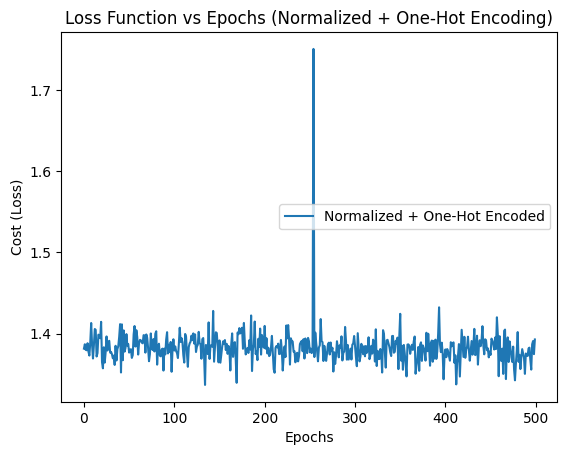

Accuracy (Normalized + One-Hot Encoding): 0.2551


In [ ]:
# One-hot encode categorical columns
X_train_encoded = pd.get_dummies(X_train_norm, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_norm, drop_first=True)

# Ensure both train and test sets have the same columns after encoding
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join="left", axis=1, fill_value=0)

# Train new model
mlp_final = TwoLayerPerceptron(n_hidden=30, epochs=500, eta=0.001, minibatch_size=64)
mlp_final.fit(X_train_encoded.values, y_train.values)

# Predictions
y_pred_final = mlp_final.predict(X_test_encoded.values)
accuracy_final = accuracy_score(y_test, y_pred_final)

# Plot loss function
plt.plot(range(len(mlp_final.cost_)), mlp_final.cost_, label="Normalized + One-Hot Encoded")
plt.xlabel("Epochs")
plt.ylabel("Cost (Loss)")
plt.title("Loss Function vs Epochs (Normalized + One-Hot Encoding)")
plt.legend()
plt.show()

# Print accuracy
print(f"Accuracy (Normalized + One-Hot Encoding): {accuracy_final:.4f}")

## Comparison of Model Performance
Here we are able to compare what each of our models do.
### Expected Results
* The first model may perform worse due to large variations in numerical features.

* The second model (with normalization) should perform better and converge more smoothly.

* The third model (with both normalization and one-hot encoding) is expected to perform the best.

In [ ]:
print(f"Accuracy (No Preprocessing): {accuracy:.4f}")
print(f"Accuracy (Normalized Features): {accuracy_norm:.4f}")
print(f"Accuracy (Normalized + One-Hot Encoding): {accuracy_final:.4f}")

Accuracy (No Preprocessing): 0.2561
Accuracy (Normalized Features): 0.2547
Accuracy (Normalized + One-Hot Encoding): 0.2566


WRITE A BIT HERE ABOUT WHAT ACTUALLY HAPPENED IN OUR COMPARISON. DID IT PERFORM AS EXPECTED?

- The first model shows as expected to perform worse without any prprocessing the dataset. This is because the feattures in the dataser were not normalized and some of the feature most likey had significantly different scales. For instance, the  population count may differ greatly from precentages between the black, white, and hispanic populations which could affect hown the model learns the data. Without normalizing the data the model struggles to properly scale the features which can cause the model to inaccurately train the model and cause bias.

- The second model used normalization to make sure all the features are equally contributed into the model during the learning process. Using normalization brought about a slight improvment in accuracy compare to the first model, and allowed for smoother convergence during training. Although there was improvement, it was small indicating that there are other factors to consider to improve the accuracy.

- The third model involved both normalization and ont-hot encoding of catergorical features. One-hot encoding helps the model interpret categorical data more effectively. However, in this case, there were no signs of improvement compared to the second model. This could bu due fact encoding might not have been large enough to make a noticeable difference in performance.

Professor said that this accuracy is around correct, and when we get to the end, we should be around 70% or higher, according to her tests.

# Modeling

#Additional Work